In [115]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def plot_img(img):
    plt.figure(figsize=(8,8))
    plt.imshow(img)
    plt.show()

def dx_cuda(img):
    res = np.zeros(img.shape, dtype=np.float32)
    for i in range(1, img.shape[0]-1):
        for j in range(1, img.shape[1] - 1):
            res[i, j] = (img[i, j-1] - img[i, j+1])/2.0
    return res

def dy_cuda(img):
    res = np.zeros(img.shape, dtype=np.float32)
    for i in range(1, img.shape[0]-1):
        for j in range(1, img.shape[1] - 1):
            res[i, j] = (img[i+1, j] - img[i-1, j])/2.0
    return res


def plot_optical_flow(img,U,V):
    '''
    Plots optical flow given U,V and one of the images
    '''
    
    # Change t if required, affects the number of arrows
    # t should be between 1 and min(U.shape[0],U.shape[1])
    t=10 
    
    # Subsample U and V to get visually pleasing output
    U1 = U[::t,::t]
    V1 = V[::t,::t]
    
    # Create meshgrid of subsampled coordinates
    r, c = img.shape[0],img.shape[1]
    cols,rows = np.meshgrid(np.linspace(0,c-1,c), np.linspace(0,r-1,r))
    cols = cols[::t,::t]
    rows = rows[::t,::t]
    
    # Plot optical flow
    plt.figure(figsize=(8,8))
    plt.imshow(img)
    plt.quiver(cols,rows,U1,V1)
    plt.show()


In [118]:
f1 = cv2.imread("icl_snippet/250.png", 0)
f2 = cv2.imread("icl_snippet/254.png", 0)
f1 = np.asarray(f1, dtype=np.float32)
f2 = np.asarray(f2, dtype=np.float32)
f1/=255.0
f2/=255.0

In [119]:
from scipy.ndimage.filters import convolve as filter2
import numpy as np
from typing import Tuple
#
HSKERN = np.array([[1/12.0, 1/6.0, 1/12.0],
                   [1/6.0,    0, 1/6.0],
                   [1/12.0, 1/6.0, 1/12.0]], float)

kernelX = np.array([[-1, 1],
                    [-1, 1]]) * .25  # kernel for computing d/dx

kernelY = np.array([[-1, -1],
                    [1, 1]]) * .25  # kernel for computing d/dy

kernelT = np.ones((2, 2))*.25


def HornSchunck(im1: np.ndarray, im2: np.ndarray, *,
                alpha: float = 0.001, Niter: int = 8,
                verbose: bool = False) -> Tuple[np.ndarray, np.ndarray]:
    """
    Parameters
    ----------
    im1: numpy.ndarray
        image at t=0
    im2: numpy.ndarray
        image at t=1
    alpha: float
        regularization constant
    Niter: int
        number of iteration
    """
    im1 = im1.astype(np.float32)
    im2 = im2.astype(np.float32)

    # set up initial velocities
    uInitial = np.zeros([im1.shape[0], im1.shape[1]])
    vInitial = np.zeros([im1.shape[0], im1.shape[1]])

    # Set initial value for the flow vectors
    U = uInitial
    V = vInitial

    # Estimate derivatives
    [fx, fy, ft] = computeDerivatives(im1, im2)

#    print(fx[100,100],fy[100,100],ft[100,100])

        # Iteration to reduce error
    for _ in range(Niter):
        # %% Compute local averages of the flow vectors
        uAvg = filter2(U, HSKERN)
        vAvg = filter2(V, HSKERN)
# %% common part of update step
        der = (fx*uAvg + fy*vAvg + ft) / (alpha**2 + fx**2 + fy**2)
# %% iterative step
        U = uAvg - fx * der
        V = vAvg - fy * der

    return U, V


def computeDerivatives(im1: np.ndarray, im2: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    fx = filter2(im1, kernelX) + filter2(im2, kernelX)
    fy = filter2(im1, kernelY) + filter2(im2, kernelY)

    # ft = im2 - im1
    ft = filter2(im1, kernelT) + filter2(im2, -kernelT)

    return fx, fy, ft


In [120]:
U, V = HornSchunck(f2, f1)

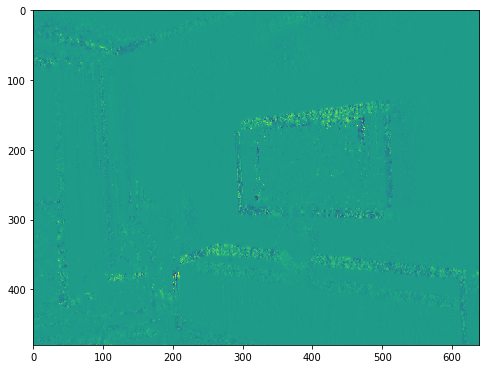

In [123]:
plot_img(U)

In [104]:
1/12

0.08333333333333333